In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [7]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [8]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [9]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [10]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [12]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [13]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
## Step 2: Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=1,hidden_size=64,num_layers=2,output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc  = nn.Linear(hidden_size,output_size)
    def forward(self, x):
        out,_=self.rnn(x)
        out=self.fc(out[:,-1,:])
        return out


In [15]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


In [17]:
from torchinfo import summary

# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=20):
    train_losses = []
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)        # (batch, seq_len, 1)
            y_batch = y_batch.to(device)        # (batch, 1)
            optimizer.zero_grad()
            outputs = model(x_batch)            # (batch, 1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            # accumulate sum of per-sample losses
            total_loss += loss.item() * x_batch.size(0)
        epoch_loss = total_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch}/{epochs}] - Train MSE: {epoch_loss:.6f}")
    return train_losses

In [22]:
# Train the model and collect losses
train_losses = train_model(model, train_loader, criterion, optimizer, device, epochs=20)


Epoch [1/20] - Train MSE: 0.045892
Epoch [2/20] - Train MSE: 0.003891
Epoch [3/20] - Train MSE: 0.000947
Epoch [4/20] - Train MSE: 0.000474
Epoch [5/20] - Train MSE: 0.000416
Epoch [6/20] - Train MSE: 0.000413
Epoch [7/20] - Train MSE: 0.000448
Epoch [8/20] - Train MSE: 0.000386
Epoch [9/20] - Train MSE: 0.000368
Epoch [10/20] - Train MSE: 0.000345
Epoch [11/20] - Train MSE: 0.000354
Epoch [12/20] - Train MSE: 0.000390
Epoch [13/20] - Train MSE: 0.000412
Epoch [14/20] - Train MSE: 0.000335
Epoch [15/20] - Train MSE: 0.000343
Epoch [16/20] - Train MSE: 0.000354
Epoch [17/20] - Train MSE: 0.000339
Epoch [18/20] - Train MSE: 0.000300
Epoch [19/20] - Train MSE: 0.000286
Epoch [20/20] - Train MSE: 0.000302


Name: Divyashree V
Register Number:212223230051


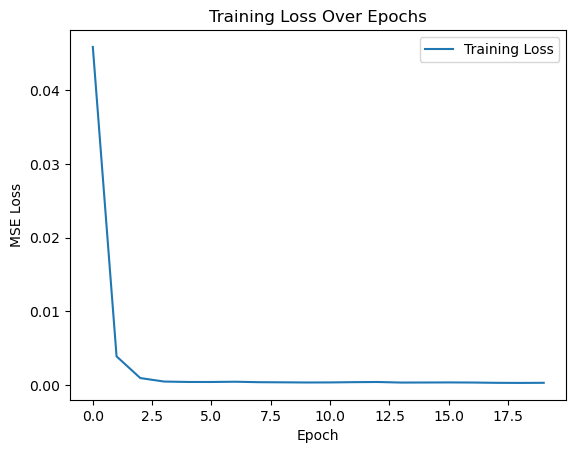

Epoch [1/20] - Train MSE: 0.000329
Epoch [2/20] - Train MSE: 0.000286
Epoch [3/20] - Train MSE: 0.000282
Epoch [4/20] - Train MSE: 0.000274
Epoch [5/20] - Train MSE: 0.000265
Epoch [6/20] - Train MSE: 0.000265
Epoch [7/20] - Train MSE: 0.000263
Epoch [8/20] - Train MSE: 0.000271
Epoch [9/20] - Train MSE: 0.000281
Epoch [10/20] - Train MSE: 0.000352
Epoch [11/20] - Train MSE: 0.000280
Epoch [12/20] - Train MSE: 0.000346
Epoch [13/20] - Train MSE: 0.000277
Epoch [14/20] - Train MSE: 0.000265
Epoch [15/20] - Train MSE: 0.000242
Epoch [16/20] - Train MSE: 0.000243
Epoch [17/20] - Train MSE: 0.000241
Epoch [18/20] - Train MSE: 0.000264
Epoch [19/20] - Train MSE: 0.000253
Epoch [20/20] - Train MSE: 0.000242


[0.00032915470585857343,
 0.0002857755295172244,
 0.0002822690876079428,
 0.00027447963114812335,
 0.00026528335254228877,
 0.00026451222938089303,
 0.0002626591360408524,
 0.0002708644741497354,
 0.00028064076840571495,
 0.00035210970166435246,
 0.0002803334002550054,
 0.0003462749221150509,
 0.0002769269708190983,
 0.000265002569757628,
 0.00024236808501858204,
 0.00024288962400977418,
 0.00024068915077195418,
 0.000263876804285407,
 0.00025254576885451355,
 0.00024193846342445905]

In [24]:
# Plot training loss
print('Name: Divyashree V')
print('Register Number:212223230051')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
train_model(model,train_loader,criterion,optimizer,device)


Name:                 
Register Number:     


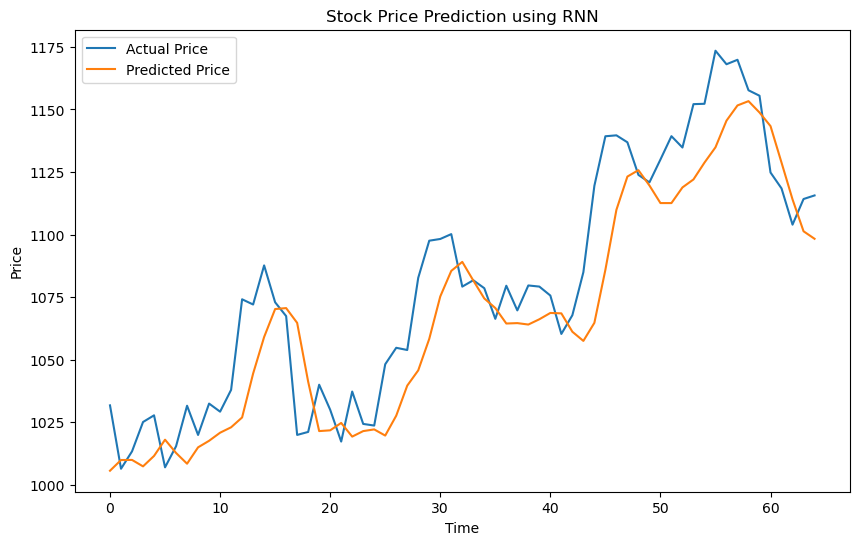

Predicted Price: [1098.3335]
Actual Price: [1115.65]


In [25]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
print('Name:                 ')
print('Register Number:     ')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')